In [1]:
# Loading Libraries
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction
In 2023, 18.5M hectares of land burned due to forest fires in the world. This is approximately the area of a country like Greece. Climate change is increasing both the number and intensity of these fires. The challenge of reducing these natural phenomena is particularly important, as they affect both local populations and ecosystems. Therefore, to what extent can atmospheric and temporal indicators be used to predict the area impacted by a forest fire? 

The number of forest fires being too large for a general, systemic analysis, we focused on the northern region of Portugal: the Montesinho park, available on the UC Irvine Machine Learning Rep.  This dataset provides information on the location, date, weather conditions and impacted area of $517$ forest fires that occurred in this region. 

## Preliminary Analysis

A zip file containing the data table is found here: [link](https://archive.ics.uci.edu/static/public/162/forest+fires.zip). To access the contents, we must unzip and write the file into a table. The code for writing the files into the table was interpolated from this [StackOverflow question](https://stackoverflow.com/questions/3053833/using-r-to-download-zipped-data-file-extract-and-import-data).

In [2]:
# Setting up data tibble from url
zip_temp <- tempfile() # temp file for .zip
extract_temp <- tempfile() # temp file for extracted .zip

download.file("https://archive.ics.uci.edu/static/public/162/forest+fires.zip", zip_temp)
unzip(zipfile=zip_temp, exdir=extract_temp)

forest_data <- read_csv(file.path(extract_temp, "forestfires.csv"))
unlink(c(zip_temp, extract_temp))

Rows: 517 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Although the data is already in a tidy format, we just need to convert the `month` and `day` variables into factors.

In [3]:
# Changing month and day to factors
forest_data <- forest_data |>
            mutate(month = as_factor(month), day=as_factor(day))

head(forest_data)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


Finally, we will separate the data into a 75/25 training testing split with equal `area` distributions

In [4]:
set.seed(3140)
forest_split <- initial_split(forest_data, prop=0.75, strata=area)
forest_training <- training(forest_split)
forest_testing <- testing(forest_split)

To get a better feel for the data table, we will collect some metrics for the variables on the dataset. First, an overview on what these values represent:

| Variable | Meaning                                                                                                                                 |
| :------: | --------------------------------------------------------------------------------------------------------------------------------------- |
|   `X`    | Normalized X coordinate relative to park bounds                                                                                         |
|   `Y`    | Normalized Y coordinate relative to park bounds                                                                                         |
| `month`  | Month                                                                                                                                   |
|  `day`   | Day of week                                                                                                                             |
|  `FFMC`  | **Fine Fuel Moisture Code** - numeric score on moisture content of litter and fine fuels - outlines ease of combustion                  |
|  `DMC`   | **Duff Moisture Code** - numeric score moisture content of organic material 5-10cm deep - indicates amount of fuel burned in that range |
|   `DC`   | **Drought Code** - measure of moisture content in deep layers - indicates long term precipitation                                       |
|  `ISI`   | **Initial Spread Index** - measure of expected speed of spread of fire                                                                  |
|  `temp`  | Temperature ($C\degree$)                                                                                                                |
|   `RH`   | Relative humidity (%)                                                                                                                   |
|  `wind`  | Wind speed in ($km/h$)                                                                                                                  |
|  `rain`  | Rainfall in the region ($mm/m^2$)                                                                                                       |
|  `area`  | Total burned area ($ha$)                                                                                                                |

For the numerical variables, we will view the mean, maximum and standard deviation, and for the categorical variables we will view their occurences: 

In [5]:

forest_categorical <- forest_training |> select(month, day)
forest_numerical <- forest_training |> select(-month, -day)

fire_by_stat <- function(fn) {
    return(map_df(forest_numerical, fn))
}


fire_mean <- fire_by_stat(mean)
fire_max <- fire_by_stat(max)
fire_median <- fire_by_stat(median)
fire_stdev <- fire_by_stat(sd)

month_appearances <- forest_categorical |> 
                    group_by(month) |>
                    summarize(count=n()) |>
                    pivot_wider(names_from="month", values_from="count")

day_appearances <- forest_categorical |> 
                    group_by(day) |>
                    summarize(count=n()) |>
                    pivot_wider(names_from="day", values_from="count")

month_appearances
day_appearances

fire_mean
fire_max
fire_stdev

mar,oct,aug,sep,apr,jun,jul,feb,jan,dec,may
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
44,10,137,130,4,15,22,14,2,7,1


fri,tue,sat,sun,mon,wed,thu
<int>,<int>,<int>,<int>,<int>,<int>,<int>
63,41,68,74,58,40,42


X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.660622,4.34456,90.73187,113.3782,549.0601,9.204922,18.91528,44.93782,4.006477,0.02694301,13.89264


X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,9,96.2,290,855.3,56.1,33.3,100,9.4,6.4,1090.84


X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.333573,1.245432,5.797868,65.47469,250.0997,4.711671,5.98364,16.75418,1.767862,0.3400527,71.90354


As this data was collected specifically for machine learning, there are no missing values in the dataset. However, note that for the `DMC` and `area` variables, they exhibit high variations and maximum values relative to the means. This skew can be shown in the below histogram:

Warning message:
“Removed 1 rows containing missing values (`geom_bar()`).”


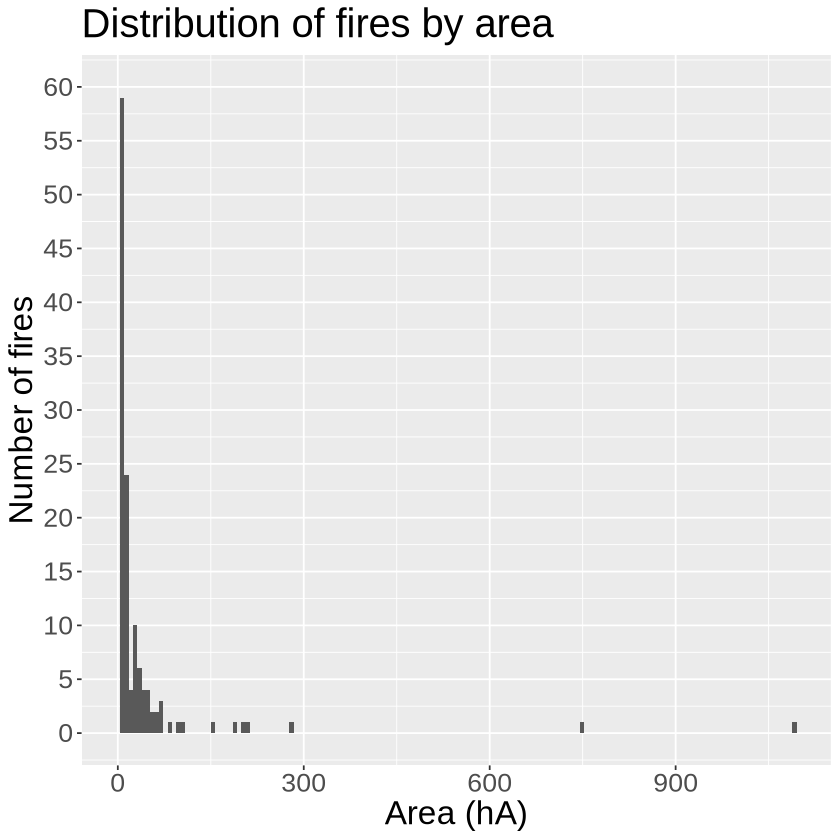

In [21]:
area_distribution_plot <- forest_training |>
                        ggplot(aes(x=area)) +
                        geom_histogram(bins=150, binwidth=7) +
                        labs(x = "Area (hA)", y="Number of fires", title="Distribution of fires by area") +
                        scale_y_continuous(limits=c(0, 60), breaks=seq(from=0, to=60, by=5)) +
                        theme(text=element_text(size=20))
                    
                        
area_distribution_plot

As we are attempting to predict `area`, we may have to upsample or remove some smaller values to reduce bias. The initial paper dealt with this skew by using logarithms.
Finally, to better show how these variables contribute to area, we include some scatterplots that relate the area to all of the numerical variables:

## Methods

## Expected Outcome and Significance

"hello"

## Bibliography